In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.impute import KNNImputer
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression,f_regression
from skfeature.function.similarity_based import fisher_score 
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor

# 1. Problem Statement

In [2]:
"""Oxygen shortage was one of the prime causes of increasing death cases of Covid 
infected patients in India. That's why the client wants to develop a strategy to 
deliver oxygen in an efficient way so that it gets utilized to its fullest and 
sustainably, thus reventing acute shortages of O2."""

# Predict the oxygen demand for various categories of patients within a given span of time and duration.
# (Oxygen demand for patients with acute respiratory syndromes)

"Oxygen shortage was one of the prime causes of increasing death cases of Covid \ninfected patients in India. That's why the client wants to develop a strategy to \ndeliver oxygen in an efficient way so that it gets utilized to its fullest and \nsustainably, thus reventing acute shortages of O2."

# 2. Data Gathering & Validation

In [3]:
df = pd.read_csv("Oxygen_demand.csv")
df.head()

,age,gender,spo2,pr,c/nc,oxy_flow
0,27,0,74.0,72.0,1.0,6.0
1,26,1,NaN,110.0,1.0,4.0
2,52,0,69.0,84.0,1.0,0.0
3,82,0,93.0,93.0,1.0,28.0
4,17,0,83.0,NaN,1.0,3.0


In [4]:
# Feature information

# age: The exact age of the patient concerned(in year)
# gender: gender of patient concerned (0 for female and 1 for male)
# spo2: The instantaneous oxygen saturation percentage of the patient concerned
# pr: The instantaneous pulse rate of the patient concerned
# c/nc: A categorical data categorizing the patient as infected with SARS (positive(1.0)/negative(0.0))

# Oxygen Flow: Doctor-prescribed instantaneous oxygen flow concentration of the patient concerned (Target variable)


# 3. EDA

In [5]:
df.describe().drop(["gender","c/nc"], axis = 1) # All the stats of the data (except gender & c/nc: categorical)

,age,spo2,pr,oxy_flow
count,139568.000000,120142.000000,115650.000000,139568.000000
mean,46.300957,88.671297,92.349209,18.680464
std,21.867571,15.489208,16.043013,17.855830
min,17.000000,35.000000,40.000000,0.000000
25%,28.000000,84.000000,82.000000,6.000000
50%,44.000000,97.000000,95.000000,16.000000
75%,62.000000,99.000000,107.000000,24.000000
max,100.000000,99.000000,110.000000,76.000000


In [6]:
df.info() # information of the featuers

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139568 entries, 0 to 139567
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   age       139568 non-null  int64  
 1   gender    139568 non-null  int64  
 2   spo2      120142 non-null  float64
 3   pr        115650 non-null  float64
 4   c/nc      139568 non-null  float64
 5   oxy_flow  139568 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 6.4 MB


In [7]:
(df.isna().sum()/200000)*100 # checking for % null values

age          0.000
gender       0.000
spo2         9.713
pr          11.959
c/nc         0.000
oxy_flow     0.000
dtype: float64

In [8]:
#cheking for unique values
for i in df.columns:
    print(f"unique values of {i}:: {df[i].nunique()}")

unique values of age:: 84
unique values of gender:: 2
unique values of spo2:: 65
unique values of pr:: 71
unique values of c/nc:: 2
unique values of oxy_flow:: 77


<AxesSubplot:title={'center':'pr distribution'}, ylabel='Density'>

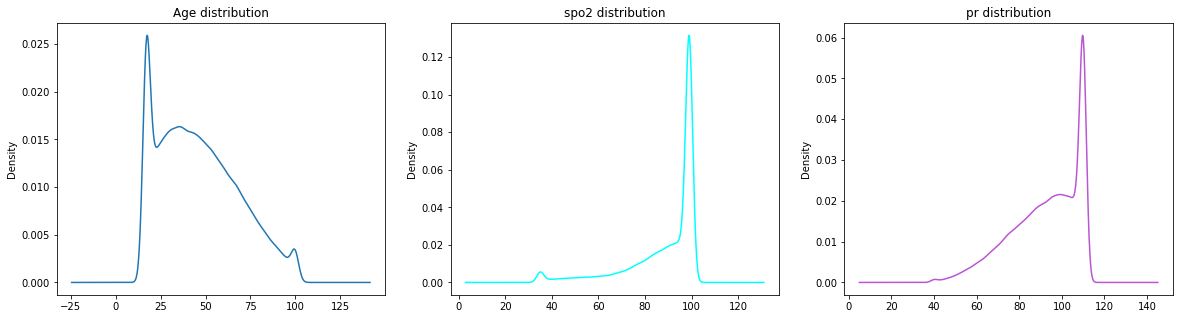

In [9]:
# checking the distribution of the data
fig, axes = plt.subplots(1, 3, figsize=(20,5))
df.age.plot(kind = "kde",ax = axes[0],title ="Age distribution" ) 
df.spo2.plot(kind = "kde",ax = axes[1],color = "aqua", title = "spo2 distribution")
df.pr.plot(kind ="kde",ax = axes[2],color = "mediumorchid", title = "pr distribution")

In [10]:
# checking in which gender the infected and disinfect patient with SARS needs how much avg age
df.pivot_table(index = "c/nc", columns = "gender", values = "age"  )

gender,0,1
c/nc,,
0.0,45.716222,45.070575
1.0,46.882684,45.831948


In [11]:
# avg age in each gender
df.groupby("gender").mean()["age"]

gender
0    46.637015
1    45.662490
Name: age, dtype: float64

In [12]:
# avg age of infected and disinfect patient with SARS in each gender
df.groupby(["gender","c/nc"]).mean()["age"]

gender  c/nc
0       0.0     45.716222
        1.0     46.882684
1       0.0     45.070575
        1.0     45.831948
Name: age, dtype: float64

<AxesSubplot:ylabel='age'>

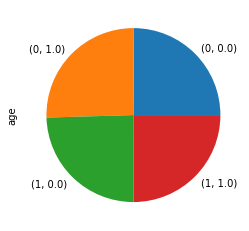

In [13]:
# bar graph of avg age of infected and disinfect patient with SARS in each gender
df.groupby(["gender","c/nc"]).mean()["age"].plot(kind ='pie')

In [14]:
# cheking either male or female needs more oxygen
df.groupby("gender").sum()['oxy_flow']

gender
0    1687962.0
1     919233.0
Name: oxy_flow, dtype: float64

In [15]:
# total oxygen, and avg oxygen flow in each category who is infected and 
# disinfacted with Severe acute respiratory syndrome (SARS)
df.groupby("c/nc")["oxy_flow"].agg(["mean","sum"])

,mean,sum
c/nc,,
0.0,19.285285,577980.0
1.0,18.515073,2029215.0


<AxesSubplot:xlabel='gender', ylabel='age'>

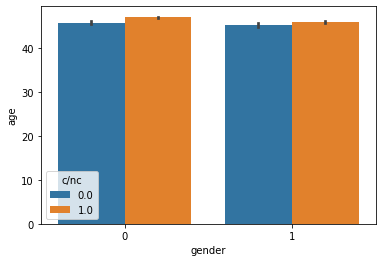

In [16]:
# bar plot of ages in each sars infected and disinfacted males and feamales
sns.barplot(x = "gender", y = "age",hue = "c/nc", data = df)

In [17]:
# checking in which gender and in which age category how many patients need how much oxy_flow
pd.crosstab(index =df.age ,columns =[df.gender,df.oxy_flow])

gender      0                                               ...    1       \
oxy_flow 0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0   ... 67.0 68.0   
age                                                         ...             
17        926  123  128  132  167  176  195  197  234  211  ...   13    5   
18        126   16   16   11   17   21   22   15   17   25  ...    1    0   
19        117   12   12   25   24   18   20   34   25   23  ...    0    2   
20        124   22   19   17   26   23   23   26   24   31  ...    2    3   
21        134   22   15   14   18   28   28   25   30   21  ...    3    1   
..        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
96         52    6    6    6    6    5    4    7    5    4  ...    1    0   
97         37    1    5    7    4    3    5    6    2    5  ...    0    0   
98         40    1    4    4    4    5    7    5    7    6  ...    1    0   
99         33    3    0    6    7    4    6    5    4    2  ...    0    0   
100       263   22   33   33   32   32   33   35   32   36  ...    0    0   

gender                                            
oxy_flow 69.0 70.0 71.0 72.0 73.0 74.0 75.0 76.0  
age                                               
17          6    6    4    2    4    9    6  262  
18          0    2    0    0    0    0    0   34  
19          1    2    3    0    0    1    0   23  
20          2    0    0    1    0    0    0   32  
21          0    0    0    0    0    1    0   29  
..        ...  ...  ...  ...  ...  ...  ...  ...  
96          0    0    0    0    1    0    0    3  
97          0    1    0    1    0    0    0    3  
98          0    0    0    1    0    1    0    6  
99          1    0    0    0    0    0    0    0  
100         2    1    0    1    2    0    1   19  

[84 rows x 154 columns]

<AxesSubplot:xlabel='pr'>

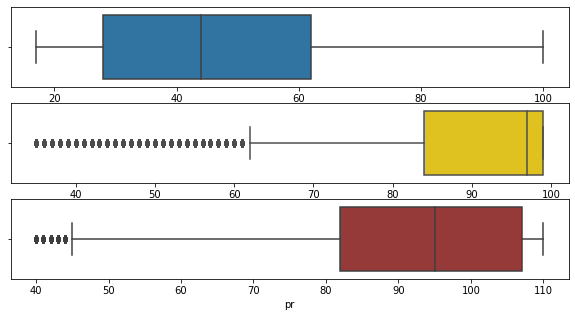

In [18]:
# checking for outliers
fig, axes = plt.subplots(3, 1, figsize=(10, 5))
sns.boxplot(df["age"],ax = axes[0])
sns.boxplot(df["spo2"], ax = axes[1],color = "gold")
sns.boxplot(df["pr"], ax = axes[2],color = "brown")

###### So now we have all the insights of the data. Here we have to handle null values as well as outliers. So now the time to do featuer engineering 

# 4. Feature Engineering

In [19]:
# first we will handle null values.
# We can fill null values with mean, but knn-imputer is one of the best choice so we will use it.
knn = KNNImputer()
arr = knn.fit_transform(df)
df1 = pd.DataFrame(arr, columns = df.columns)
df1.head()

,age,gender,spo2,pr,c/nc,oxy_flow
0,27.0,0.0,74.0,72.0,1.0,6.0
1,26.0,1.0,77.4,110.0,1.0,4.0
2,52.0,0.0,69.0,84.0,1.0,0.0
3,82.0,0.0,93.0,93.0,1.0,28.0
4,17.0,0.0,83.0,92.6,1.0,3.0


In [20]:
df1.isna().sum()

age         0
gender      0
spo2        0
pr          0
c/nc        0
oxy_flow    0
dtype: int64

In [21]:
# now we use z_score for finding the outliers
# Normal SpO2 values vary between 90 and 100%

z_val = stats.zscore(df1["spo2"])
z_val = np.abs(z_val)
threshold = 3
outliers = np.where(z_val >= threshold)
df1["spo2"][outliers[0]]

96        35.0
108       35.0
175       42.0
224       39.0
230       38.0
          ... 
139471    42.0
139477    38.0
139524    43.0
139546    35.0
139551    35.0
Name: spo2, Length: 4100, dtype: float64

In [22]:
# A normal pulse rate for adults is between 60 and 100 beats per minute.
# Similar to spo2 we will use scaling for pr feature also.

z_scr = stats.zscore(df1["pr"])
z_scr = np.abs(z_scr)
threshold = 3
outliers1 = np.where(z_scr >= threshold)
df1["pr"][outliers1[0]]

46        40.0
86        40.0
233       47.0
255       47.0
484       40.0
          ... 
139240    45.0
139311    46.0
139330    40.0
139341    43.0
139496    40.0
Name: pr, Length: 824, dtype: float64

###### let's check the mean value of the featuer, wich is 88. But  if we replace outliers with 88 so it will be around normal range.
###### So we will not handle outliers because we needs actual information.  But we can reduce the impact by using scaling.

# 5. Feature Selection

In [23]:
# less corellation between depedent and independent variables
df1.corr()[-1:][["age","spo2","pr"]] #(independent cont and dependent cont) 

,age,spo2,pr
oxy_flow,-0.073438,-0.026834,-0.06514


In [24]:
# less corellation between dependent and independent variables
df1.corr(method = "kendall")[-1:][["gender","c/nc"]] # (independent cat and dependent con)

,gender,c/nc
oxy_flow,0.022293,-0.021928


In [25]:
# taking mutual information # telling all the featuers are giving information exept c/nc
arr = mutual_info_regression(df1.drop("oxy_flow", axis = 1), df1["oxy_flow"])
pd.Series(arr, index = df1.drop("oxy_flow", axis = 1).columns)

age       0.007584
gender    0.000000
spo2      0.007281
pr        0.017459
c/nc      0.000000
dtype: float64

In [26]:
# conducting Annova Test # telling all the featues are good for model (cat VS cont)
f_val,p_val = f_regression(df1.drop("oxy_flow", axis = 1), df1["oxy_flow"])
pd.DataFrame({"F_val":np.around(f_val,2), "P_val": np.around(p_val,2)}, index = df1.drop("oxy_flow", axis = 1).columns)


,F_val,P_val
age,756.77,0.0
gender,40.44,0.0
spo2,100.57,0.0
pr,594.74,0.0
c/nc,43.80,0.0


<AxesSubplot:>

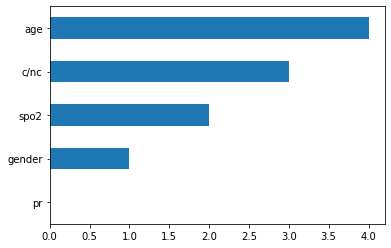

In [27]:
# fisher score telling only pr is not important but we can not drop it as different tests told that pr is important
fisher_scr = fisher_score.fisher_score(df1.drop("oxy_flow", axis = 1)[0:5000].to_numpy(),df1["oxy_flow"][0:5000])
s = pd.Series(fisher_scr,index = df1.drop("oxy_flow", axis = 1).columns)
s.sort_values().plot(kind = "barh")

###### After conducting all the feature selection techniques, we can conclude that there is no featuer to drop

# 6. Model Selection & Training

In [28]:
x = df1.drop("oxy_flow", axis = 1)
y = df1["oxy_flow"]

In [43]:
# spliting the data for training as well as testing purpose
x_train,x_test,y_train,y_test = train_test_split(x,y, random_state=42,test_size=0.35 )

###### We have to split our data into training and testing purpose before going for scaling to skip data leakage.

In [44]:
# scaling to reduce impact of the outliers (fit only on training data)
std = StandardScaler()
arr = std.fit_transform(x_train)
std_x_tr = pd.DataFrame(arr,columns = x_train.columns)
std_x_tr

,age,gender,spo2,pr,c/nc
0,-1.341253,-0.723771,0.569698,-1.493465,0.522818
1,0.898132,1.381653,0.706798,0.183700,0.522818
2,-1.112744,-0.723771,-1.075505,0.988740,0.522818
3,-1.341253,1.381653,0.706798,0.317874,0.522818
4,-1.341253,1.381653,-0.047253,-0.487166,0.522818
...,...,...,...,...,...
90714,-0.061604,1.381653,0.158397,1.190000,-1.912712
90715,1.903570,-0.723771,0.638248,-0.285906,0.522818
90716,-0.975639,-0.723771,0.706798,0.519134,-1.912712
90717,1.492254,1.381653,0.144687,1.190000,-1.912712


In [45]:
# Now we will scale test data set values
arr2 = std.transform(x_test)
std_x_te= pd.DataFrame(arr2,columns = x_test.columns)
std_x_te

,age,gender,spo2,pr,c/nc
0,-1.249849,-0.723771,0.706798,0.586220,0.522818
1,-1.341253,-0.723771,-0.184354,-0.889685,0.522818
2,-1.249849,1.381653,-0.869855,-2.701024,0.522818
3,2.223482,-0.723771,0.706798,1.190000,0.522818
4,-0.655727,-0.723771,0.007587,-0.956772,0.522818
...,...,...,...,...,...
48844,-1.158446,1.381653,-1.761006,-0.030977,-1.912712
48845,-0.472920,1.381653,0.706798,-0.151733,0.522818
48846,0.441115,-0.723771,0.706798,-0.420079,0.522818
48847,1.446553,1.381653,0.706798,-0.822599,0.522818


In [46]:
models = [("linear_regression",LinearRegression()),("DT", DecisionTreeRegressor()),
          ("Random_Forest",RandomForestRegressor()),("KNN",KNeighborsRegressor())]
for name,model in models:
    model.fit(std_x_tr,y_train)
    pred = model.predict(std_x_tr)
    pred1 = model.predict(std_x_te)
    print(f"""the accuracies of {name} model 
          (Training: {r2_score(y_train,pred)}) 
          (Test: {r2_score(y_test,pred1)})""" )
    print(f"""the mse of {name} model 
          (Training: {mean_absolute_error(y_train,pred)}) 
          (Test: {mean_absolute_error(y_test,pred1)}) """)
    print("*"*30)
    

the accuracies of linear_regression model 
          (Training: 0.010773712055877627) 
          (Test: 0.010662927950376933)
the mse of linear_regression model 
          (Training: 12.381505821643579) 
          (Test: 12.398824227964312) 
******************************
the accuracies of DT model 
          (Training: 0.7317988266712216) 
          (Test: -0.7351391773429956)
the mse of DT model 
          (Training: 4.103502641544424) 
          (Test: 16.17876786386259) 
******************************
the accuracies of Random_Forest model 
          (Training: 0.637010939517058) 
          (Test: -0.13617173017835205)
the mse of Random_Forest model 
          (Training: 7.100588023295455) 
          (Test: 13.462902571490543) 
******************************
the accuracies of KNN model 
          (Training: 0.1992617366497137) 
          (Test: -0.16193438107410185)
the mse of KNN model 
          (Training: 11.482648618260784) 
          (Test: 13.77615509017585) 
*****************

###### As we can see the accuracy of DT model is giving goodness of best fit line. So, we will go forward with the model

In [ ]:
# Hyper parameter tuning
model = DecisionTreeRegressor()
param = {"criterion":["mse","mae"], "max_depth": np.arange(2,30),
         "min_samples_split": np.arange(2,20), "min_samples_leaf": np.arange(1,10),
         "random_state": [42,43,44,45]}
grscv = GridSearchCV(model,param,cv=5)
grscv.fit(std_x_tr,y_train)
grscv.best_estimator_

# pre pruning
dt_1 = DecisionTreeClassifier(random_state=45,ccp_alpha=0.0)
dt_1.fit(std_x_tr,y_train)

#post pruning
dictt = dt_1.cost_complexity_pruning_path(std_x_tr,y_train)
ccp_alphas = dictt["ccp_alphas"]
train_accuracy_list = []
test_accuracy_list = []
for ccp_val in ccp_alphas:
    if ccp_val > 0:
        dt_2 = DecisionTreeClassifier(random_state = 42,ccp_alpha = ccp_val)
        dt_2.fit(std_x_tr,y_train)
        train_accuracy_list.append(dt_2.score(std_x_tr,y_train))
        test_accuracy_list.append(dt_2.score(std_x_te,y_test))

index = np.where(test_accuracy_list == np.max(test_accuracy_list))
for i in index[0]:
    print(f"at the {ccp_alphas[i]} ccp_alpha value, \nwe will get {train_accuracy_list[i]} training accuracy \nand {test_accuracy_list[i]} testing accuracy")
    print("#"*50)

# for cheking the model
age_of_car = 0.090
age_of_policyholder = 0.471
area_cluster = "C11"
population_density = 0.901
make = 3
segment = "C1"
model = "M2"
fuel_type = "Petrol"
engine_type = "F8D Petrol Engine"
rear_brakes_type = "Drum"
transmission_type = "Manual"
gear_box = 5
steering_type = "Manual"


# __________________________________________________________________________________________________________________

test_array = np.zeros(smt_x.shape[1])
column_names = smt_x.columns
test_array[0] = age_of_car
test_array[1] = age_of_policyholder
test_array[2] = data_dict['area_cluster'][area_cluster]
test_array[3] = population_density
test_array[4] = make
test_array[5] = data_dict['segment'][segment]
test_array[6] = data_dict['model'][model]
test_array[7] = data_dict['fuel_type'][fuel_type]
test_array[8] = data_dict['engine_type'][engine_type]
test_array[9] = data_dict['rear_brakes_type'][rear_brakes_type]
test_array[10] = data_dict['transmission_type'][transmission_type]
test_array[11] = gear_box
test_array[12] = data_dict['steering_type'][steering_type]